In [1]:
import pyreadr

import numpy as np
import pandas as pd

from sklearn import preprocessing
from scipy.special import comb, logsumexp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

import keras
from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [21]:
actual_path = "../data/building_energy_actual.rds"
sim_path = "../data/building_energy_sim.rds"

e_actual = pyreadr.read_r(actual_path)[None]
e_sim = pyreadr.read_r(sim_path)[None]

In [22]:
e_sim = e_sim.filter(['apn', 'kwh', 'year', 'month', 'day', 'hour'])
e_sim = e_sim.rename(columns={"kwh": "kwh_sim"})

In [23]:
e_merged = e_actual.merge(e_sim, on=['apn', 'year', 'month', 'day', 'hour'], how='inner')
e_merged = e_merged.dropna()
e_merged = e_merged.filter(items=['apn', 'kwh', 'kwh_sim', 'year', 'month', 'day', 'hour', 'year_built', 'num_stories', 'ground_floor', 'net_rental'])
e_merged['kwh'] = e_merged['kwh'].astype(int)

In [24]:
e_merged

,apn,kwh,kwh_sim,year,month,day,hour,year_built,num_stories,ground_floor,net_rental
0,00601010190000,6,4,2016.0,1.0,1,1,1900,1,8150,8150
1,00601010190000,6,4,2016.0,1.0,1,2,1900,1,8150,8150
2,00601010190000,7,4,2016.0,1.0,1,3,1900,1,8150,8150
3,00601010190000,6,4,2016.0,1.0,1,4,1900,1,8150,8150
4,00601010190000,6,4,2016.0,1.0,1,5,1900,1,8150,8150
...,...,...,...,...,...,...,...,...,...,...,...
829619,00600470060000,16,36,2018.0,12.0,31,19,1920,3,4000,8162
829620,00600470060000,15,35,2018.0,12.0,31,20,1920,3,4000,8162
829621,00600470060000,14,33,2018.0,12.0,31,21,1920,3,4000,8162
829622,00600470060000,12,30,2018.0,12.0,31,22,1920,3,4000,8162


In [25]:
e_merged.dtypes

apn              object
kwh               int32
kwh_sim           int32
year            float64
month           float64
day               int32
hour              int32
year_built        int32
num_stories       int32
ground_floor      int32
net_rental        int32
dtype: object

In [26]:
X = e_merged.drop(columns=['kwh'])
y = e_merged.filter(items=['kwh'])

In [43]:
test = e_merged.filter(items=['apn', 'kwh'])
np.mean(test[test['apn'] == '00601010210000'])

apn          inf
kwh    23.293008
dtype: float64

In [76]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled[0] = X['apn']

X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X_scaled, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5)

train_apn = X_train[0]
val_apn = X_val[0]
test_apn = X_test[0]

X_train = X_train.drop(columns=[0]).values
X_val = X_val.drop(columns=[0]).values
X_test = X_test.drop(columns=[0]).values

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(580692, 9) (124434, 9) (124434, 9) (580692, 1) (124434, 1) (124434, 1)


In [134]:
reg = GradientBoostingRegressor().fit(X_train, y_train.values.ravel())
# mean_absolute_error(y_val, reg.predict(X_val))
# reg.score(X_val, y_val)
# model = Sequential([
#     Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
#     Dense(32, activation='relu'),
#     Dense(1, activation='sigmoid'),
# ])

# model.compile(optimizer='sgd',
#               loss='mean_squared_error',
#               metrics=['accuracy'])

# hist = model.fit(X_train, y_train,
#           batch_size=32, epochs=100,
#           validation_data=(X_val, y_val))

# reg.score(X_train, y_train)

y_predicted = reg.predict(X_val)
mean_absolute_error(y_val, y_predicted)

43.49157046515096

In [203]:
y_predicted_summary = pd.concat([pd.DataFrame(y_predicted, columns=['kwh']), pd.DataFrame(np.array(val_apn), columns=['apn']).reset_index(drop=True)], axis=1)
y_predicted_summary = y_predicted_summary.groupby(['apn']).agg({'kwh' : 'mean'}).rename(columns={"kwh": "kwh_predicted"})
e_merged_summary = e_merged.groupby(['apn']).agg({'kwh' : 'mean', 'kwh_sim' : 'mean'})
model_output = y_predicted_summary.merge(e_merged_summary, on=['apn'], how='left')
model_output = model_output[['kwh_sim', 'kwh_predicted', 'kwh']]

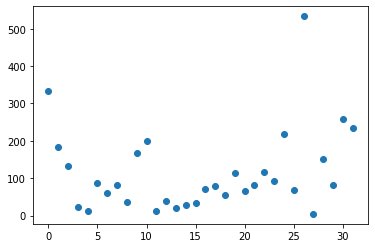

In [217]:
plt.scatter(range(0, 32), model_output['kwh_sim'])

In [228]:
y

,kwh
0,6
1,6
2,7
3,6
4,6
...,...
829619,16
829620,15
829621,14
829622,12
